In [ ]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex6 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("../input/fe-course-data/ames.csv")

In [ ]:
df.select_dtypes(["object"]).nunique()
df["SaleType"].value_counts()

### Choose Features for encoding

In [ ]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

### Apply M-Estimate Encoding

In [ ]:
encoder = MEstimateEncoder(
    cols=["Neighborhood"],
    m=1.0,
)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

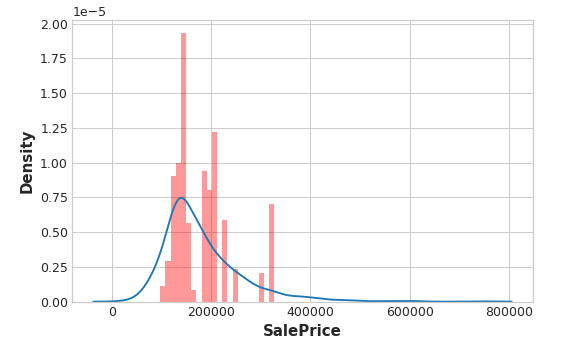

In [ ]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

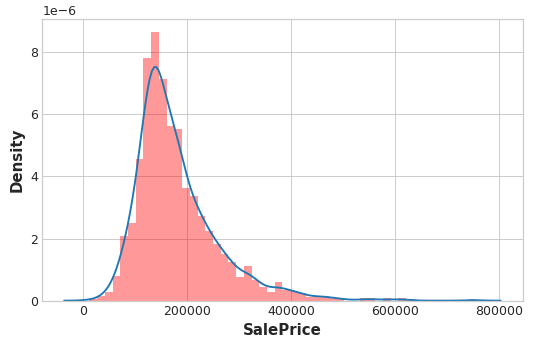